# PROJECT 1 GROUP 4: DATA CLEANING

In [ ]:
#merging Europe Emmissions by Country and World Bank Dataframes:

In [40]:
#EMISSIONS CSV CLEANING

import pandas as pd
Emissions_dataframe = pd.read_csv("Europe Emissions by Country_2023.csv", low_memory = False)
#Emissions_dataframe.head()

#Filter and Clean columns:
emissions_summary = Emissions_dataframe[['Country name','Gas/Scope','Emissions','Description as in CRF']]
emissions_summary = emissions_summary.rename(columns={"Country name": "Country Name", 
                                    "Gas/Scope": "Gas Type","Description as in CRF":"Emissions Activity Description"})
emissions_summary = emissions_summary.dropna(how='any')
emissions_summary["Emissions"] = emissions_summary["Emissions"].astype(float)
emissions_summary["Country Name"] = emissions_summary["Country Name"].astype(str)
emissions_summary["Gas Type"] = emissions_summary["Gas Type"].astype(str)
emissions_summary["Emissions Activity Description"] = emissions_summary["Emissions Activity Description"].astype(str)
emissions_summary.head()


,Country Name,Gas Type,Emissions,Emissions Activity Description
0,European Union (EU27),Total,2859489.22,Total (net emissions)(1)
1,European Union (EU27),CO2,2227112.31,Total (net emissions)(1)
2,European Union (EU27),Total,797184.12,Transportation
3,European Union (EU27),CO2,788039.49,Transportation
4,European Union (EU27),Total,694860.59,Energy Industry


In [41]:
#WORLD BANK CLEANING
import json
import requests
import pandas as pd
import numpy as np
from pprint import pprint

url = "http://api.worldbank.org/v2/"
api_format = "json"

country_name = []
country_capital = []
latitude = []
longitude = []
income_level = []
region = []


page = 1
all_countries = []
for page in range(10):
    # Get country information in JSON format for each page
    response = requests.get(f"{url}countries?format={api_format}&page={page + 1}").json()
    # Check if there's data on this page; if not, break the loop
    if response[1] is None:
        break
    # Add countries from the current page to the list
    all_countries.extend(response[1])
    # page += 1  # Move to the next page
# Print all country information
#for country in all_countries:
    #print(country)

#Appending Data to Lists to be used in Dataframe

for country in all_countries:
    country_name.append(country['name'])
    country_capital.append(country['capitalCity'])
    latitude.append(country['latitude'])
    longitude.append(country['longitude'])
    income_level.append(country['incomeLevel']['value'])
    region.append(country['region']['value'])

#Creating Dataframe with extracted data
country_dict = {
    "Country Name": country_name,
    "Capital City": country_capital,
    "Latitude": latitude,
    "Longitude": longitude,
    "Income Level": income_level,
    "Region": region
}
country_data = pd.DataFrame(country_dict)
#country_data.head()

#Cleaning Dataframe
#Filtering to Countries that are Europe and Central Asia
country_data = country_data.loc[(country_data["Region"] == "Europe & Central Asia") | (country_data["Region"] == "Europe & Central Asia (exlcuding high income)"),:]
#country_data.head()

#Removing Blank Values & Resetting Index
#country_data = country_data[country_data["Capital City"].notna()]
country_data = country_data.drop(48)
country_data = country_data.reset_index(drop = True)
country_data.head()

,Country Name,Capital City,Latitude,Longitude,Income Level,Region
0,Albania,Tirane,41.3317,19.8172,Upper middle income,Europe & Central Asia
1,Andorra,Andorra la Vella,42.5075,1.5218,High income,Europe & Central Asia
2,Armenia,Yerevan,40.1596,44.509,Upper middle income,Europe & Central Asia
3,Austria,Vienna,48.2201,16.3798,High income,Europe & Central Asia
4,Azerbaijan,Baku,40.3834,49.8932,Upper middle income,Europe & Central Asia


In [42]:
#MERGING DATA 

merged_country_emissions = pd.merge(country_data,emissions_summary,on="Country Name", how="outer")
merged_country_emissions = merged_country_emissions.loc[(merged_country_emissions["Country Name"] != "Bosnia and Herzegovina") 
& (merged_country_emissions["Country Name"] != "Belarus") & (merged_country_emissions["Country Name"] != "Azerbaijan") 
& (merged_country_emissions["Country Name"] != "Armenia") & (merged_country_emissions["Country Name"] != "Andorra") 
& (merged_country_emissions["Country Name"] != "Albania")& (merged_country_emissions["Country Name"] != "European Union (EU27)")
& (merged_country_emissions["Country Name"] != "Malta") & (merged_country_emissions["Country Name"] != "Slovakia")
,:]
#merged_country_emissions["Latitude"].replace("", np.nan, inplace=True)
#merged_country_emissions["Longitude"].replace("", np.nan, inplace=True)
merged_country_emissions["Latitude"] = pd.to_numeric(merged_country_emissions["Latitude"], errors='coerce')
merged_country_emissions["Longitude"] = pd.to_numeric(merged_country_emissions["Longitude"], errors='coerce')
#df = merged_country_emissions.dropna()
#print(merged_country_emissions.isna().sum())
#print(np.isinf(merged_country_emissions).sum())
#merged_country_emissions = merged_country_emissions.dropna(how='any')
#merged_country_emissions = pd.to_numeric(merged_country_emissions["Emissions"], downcast='integer')
merged_country_emissions.head()

#total_countries = merged_country_emissions["Country Name"].unique()
#total_countries

#Deleting Rows with low counts: 
#descriptions_unique = merged_country_emissions["Country Name"].value_counts()
#descriptions_unique


,Country Name,Capital City,Latitude,Longitude,Income Level,Region,Gas Type,Emissions,Emissions Activity Description
3,Austria,Vienna,48.2201,16.3798,High income,Europe & Central Asia,Total,63695.76,Total (net emissions)(1)
4,Austria,Vienna,48.2201,16.3798,High income,Europe & Central Asia,CO2,52355.27,Total (net emissions)(1)
5,Austria,Vienna,48.2201,16.3798,High income,Europe & Central Asia,Total,19810.35,Transportation
6,Austria,Vienna,48.2201,16.3798,High income,Europe & Central Asia,non-ETS,19748.50,Transportation
7,Austria,Vienna,48.2201,16.3798,High income,Europe & Central Asia,CO2,19566.01,Transportation


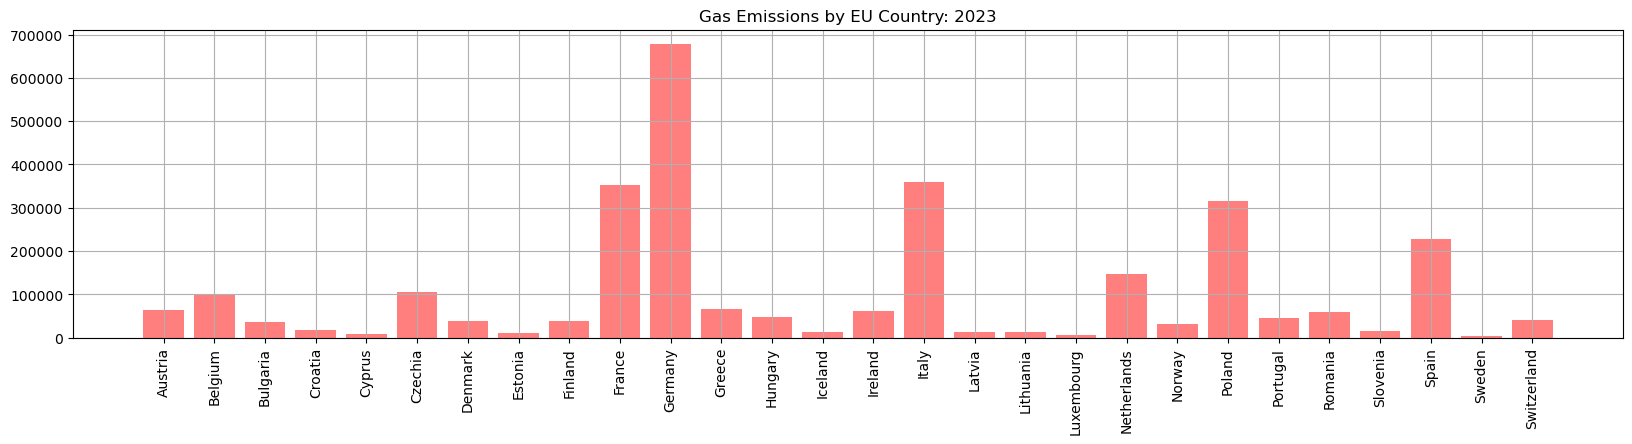

In [43]:
#WHAT ARE EMISSION AMOUNTS BY COUNTRY?
import numpy as np
import matplotlib.pyplot as plt
total_emissions_df = merged_country_emissions.loc[(merged_country_emissions["Emissions Activity Description"] == "Total (net emissions)(1)") & (merged_country_emissions["Gas Type"] == "Total"),:]
#total_emissions_df
country = total_emissions_df["Country Name"]
total_emissions = total_emissions_df["Emissions"]
plt.figure(figsize = (20,4))
plt.bar(country, total_emissions, color = "r", alpha=0.5, align="center")
plt.xticks(country, rotation="vertical")
plt.grid()
plt.title("Gas Emissions by EU Country: 2023")
#plt.ylim(50000 max(total_emissions)+10000)
plt.show()

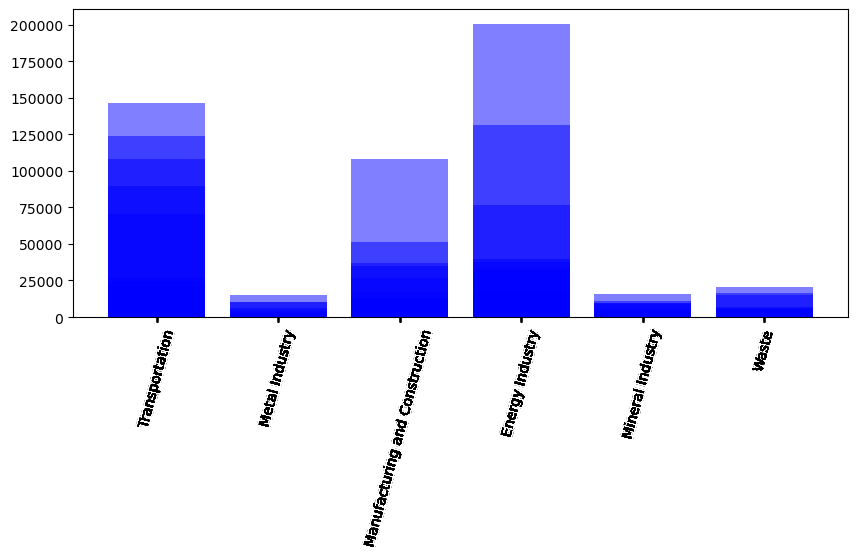

In [44]:
#SHARE BY TYPE OF EMISSIONS, OVERLAP WITH BAR CHART TOTAL EMISSIONS
#need to figure out how to show countries as colors
total_emissions_df = merged_country_emissions.loc[((merged_country_emissions["Gas Type"] == "Total") & (merged_country_emissions["Emissions Activity Description"] != "Total (net emissions)(1)")),:]
emissions_type = total_emissions_df["Emissions Activity Description"]
total_emissions = total_emissions_df["Emissions"]
#countries = total_emissions_df["Country Name"]
plt.figure(figsize = (10,4))
plt.bar(emissions_type, total_emissions, color = "b", alpha=0.5, align="center")
plt.xticks(emissions_type, rotation=75)
plt.show()

In [45]:
total_emissions_df = merged_country_emissions.loc[((merged_country_emissions["Gas Type"] == "Total") & (merged_country_emissions["Emissions Activity Description"] == "Total (net emissions)(1)")),:]
total_emissions_df["Emissions"].describe()

count        28.000000
mean     104078.906429
std      152965.539819
min        2999.930000
25%       13991.507500
50%       43769.560000
75%      100297.292500
max      677567.520000
Name: Emissions, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x17e2ef940>,
 'caps': [<matplotlib.lines.Line2D at 0x17e2efe50>,
 'boxes': [<matplotlib.lines.Line2D at 0x17e2ef6a0>],
 'medians': [<matplotlib.lines.Line2D at 0x17e3103d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x17e3104c0>],
 'means': []}

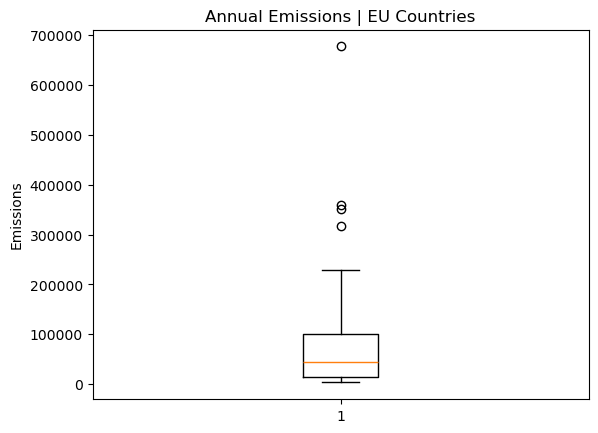

In [46]:
# BOX AND WHISKER: 

emissions = total_emissions_df["Emissions"]
plt.title('Annual Emissions | EU Countries')
plt.ylabel('Emissions')
plt.boxplot(emissions)


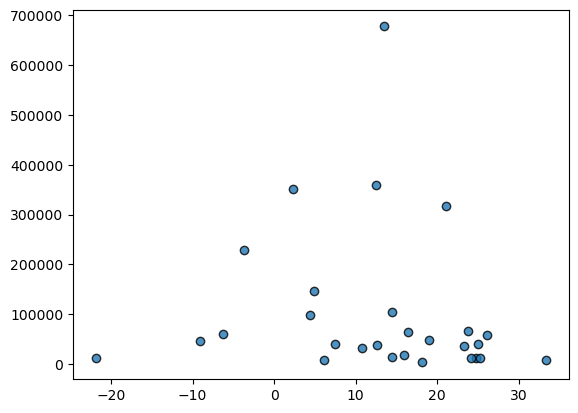

In [47]:
#SCATTERPLOT - EASTERN EUROPE VS. WESTERN EUROPE --> WITH COLORS FOR LOW VS. MEDIUM VS. HIGH INCOME


plt.scatter(     
    total_emissions_df["Longitude"],
    total_emissions_df["Emissions"],
    edgecolor="black",
    linewidths=1,
    marker="o", 
    alpha=0.8,
    label= "Country Name"
)


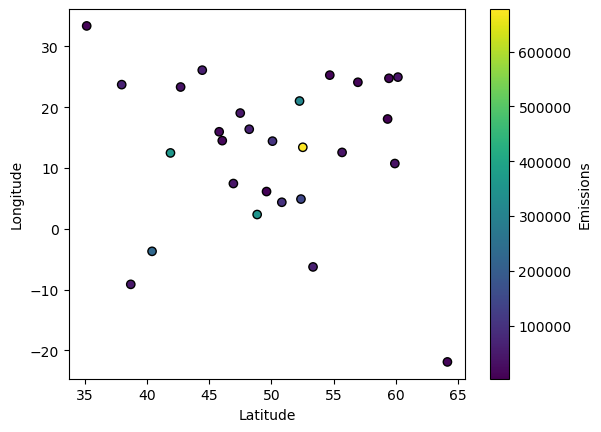

In [48]:
#SCATTERPLOT - EASTERN EUROPE VS. WESTERN EUROPE --> WITH COLORS FOR LOW VS. MEDIUM VS. HIGH INCOME


plt.scatter(     
    total_emissions_df["Latitude"],
    total_emissions_df["Longitude"],
    edgecolor="black",
    c = total_emissions_df["Emissions"]
)
clb = plt.colorbar()
plt.xlabel("Latitude")
plt.ylabel("Longitude")
clb.set_label("Emissions")
plt.show()


In [51]:
# relationship tests: latitude and longitude with emissions:
import scipy.stats as st
total_emissions_df = total_emissions_df.loc[(total_emissions_df["Longitude"] != "NaN"),:]
#total_emissions_df

longitude = total_emissions_df["Longitude"]
emissions = total_emissions_df["Emissions"]
correlation = st.pearsonr(longitude,emissions)
print("The correlation between longitude and emissions is " + str(correlation))


The correlation between longitude and emissions is PearsonRResult(statistic=-0.1110119121562874, pvalue=0.5738563932723585)


In [53]:
# relationship tests: latitude and longitude with emissions:
import scipy.stats as st
total_emissions_df = total_emissions_df.loc[(total_emissions_df["Longitude"] != "NaN"),:]
#total_emissions_df

longitude = total_emissions_df["Latitude"]
emissions = total_emissions_df["Emissions"]
correlation = st.pearsonr(longitude,emissions)
print("The correlation between latitude and emissions is " + str(correlation))


The correlation between latitude and emissions is PearsonRResult(statistic=-0.10241977849720856, pvalue=0.6040307324703169)


In [50]:
total_emissions_df

,Country Name,Capital City,Latitude,Longitude,Income Level,Region,Gas Type,Emissions,Emissions Activity Description
3,Austria,Vienna,48.2201,16.37980,High income,Europe & Central Asia,Total,63695.76,Total (net emissions)(1)
45,Belgium,Brussels,50.8371,4.36761,High income,Europe & Central Asia,Total,98865.88,Total (net emissions)(1)
85,Bulgaria,Sofia,42.7105,23.32380,High income,Europe & Central Asia,Total,35518.42,Total (net emissions)(1)
131,Croatia,Zagreb,45.8069,15.96140,High income,Europe & Central Asia,Total,18005.53,Total (net emissions)(1)
162,Cyprus,Nicosia,35.1676,33.37360,High income,Europe & Central Asia,Total,8502.22,Total (net emissions)(1)
191,Czechia,Prague,50.0878,14.42050,High income,Europe & Central Asia,Total,104591.53,Total (net emissions)(1)
229,Denmark,Copenhagen,55.6763,12.56810,High income,Europe & Central Asia,Total,39077.47,Total (net emissions)(1)
267,Estonia,Tallinn,59.4392,24.75860,High income,Europe & Central Asia,Total,11628.57,Total (net emissions)(1)
337,Finland,Helsinki,60.1608,24.95250,High income,Europe & Central Asia,Total,39231.70,Total (net emissions)(1)
367,France,Paris,48.8566,2.35097,High income,Europe & Central Asia,Total,352203.60,Total (net emissions)(1)


In [39]:
#MAP - SHOW THE COUNTRIES WE ARE LOOKING AT WITH SIZE BUBBLES BASED ON EMISSIONS
import hvplot.pandas
import pandas as pd

total_emissions_df = merged_country_emissions.loc[((merged_country_emissions["Gas Type"] == "Total") & (merged_country_emissions["Emissions Activity Description"] == "Total (net emissions)(1)") & (merged_country_emissions["Emissions"].sum() > 1)),:]

# Turn off warning messages
import warnings
warnings.filterwarnings("ignore")

map_plot_2 = total_emissions_df.hvplot.points(
    "Latitude",
    "Longitude",
    geo = True,
    tiles="EsriImagery",  # Using a different tile service
    frame_width = 1000,
    frame_height = 1000,
    size = "Emissions",
    scale = 0.5,
    color = "Income Level"
)

map_plot_2

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Latitude,Longitude]   (Income Level,Emissions)